# Clustering tracks using KMeans and finding the nearest tracks to the clusters centers per each clustering session

# Imports:

In [1]:
import MySQLdb
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append('../')
import myenvvar
from sklearn.cluster import KMeans
import datetime as dt

# Create DB connection

In [2]:
conn = MySQLdb.Connection(
        host=myenvvar.db_vars['host'],
        user=myenvvar.db_vars['user'],
        passwd=myenvvar.db_vars['password'],
        port=myenvvar.db_vars['port'],
        db=myenvvar.db_vars['db']
        )

# Import kmeans_clustering_params table from DB into df

In [3]:
q = "SELECT * FROM kmeans_clustering_params"
kmeans_clustering_params_df = pd.read_sql(q, conn)

In [4]:
kmeans_clustering_params_df.head()

clustering_datetime  random_state  k  interia_score
0 2020-06-08 07:39:06             3  4      278.98907
1 2020-06-08 10:15:39             3  4      296.64117
2 2020-06-10 08:10:00             3  4      327.25442
3 2020-06-12 09:53:38             3  5      338.20297

# Import kmeans_clustering_params table from DB into df

In [5]:
q = "SELECT * FROM kmeans_clustering_centroids"
kmeans_clustering_centroids_df = pd.read_sql(q, conn)

In [6]:
kmeans_clustering_centroids_df.head()

clustering_datetime  cluster_number  danceability_c  energy_c  loudness_c  \
0 2020-06-08 07:39:06               0         0.63331   0.43852     0.57906   
1 2020-06-08 07:39:06               1         0.65696   0.35716     0.50855   
2 2020-06-08 07:39:06               2         0.64188   0.73599     0.67261   
3 2020-06-08 07:39:06               3         0.64076   0.75129     0.73627   
4 2020-06-08 10:15:39               0         0.64482   0.73588     0.66794   

   speechiness_c  acousticness_c  instrumentalness_c  liveness_c  valence_c  \
0        0.11503         0.55891             0.09910     0.16212    0.42861   
1        0.09188         0.67125             0.83930     0.14519    0.37126   
2        0.05511         0.04879             0.77775     0.20413    0.27952   
3        0.09015         0.07814             0.05810     0.17893    0.46776   
4        0.05619         0.04913             0.77476     0.20069    0.28655   

   tempo_c  
0  0.46887  
1  0.41454  
2  0.56177  
3  0.51825  
4  0.51462

# Helper func: filter tracks for added_datetime

In [9]:
def get_tracks_features_per_clustering_date_df(clustering_datetime):
    q = "select * from audio_features af where af.added_datetime <" +"'"+ str(clustering_datetime) + "'" # selects the exact tracks that were clustered at this date
    tracks_features_per_clustering_date_df = pd.read_sql(q, conn)
    cols_to_drop = ['key', 'time_signature', 'total_available_markets', 'mode', 'duration_ms','popularity','added_datetime']
    tracks_features_per_clustering_date_df = tracks_features_per_clustering_date_df.drop(cols_to_drop, axis=1)
    tracks_features_per_clustering_date_df.set_index('track_id',inplace=True)
    # normalyze / scale features
    for col in ['loudness', 'tempo']:
        tracks_features_per_clustering_date_df[col] = ((tracks_features_per_clustering_date_df[col] - tracks_features_per_clustering_date_df[col].min()) / (tracks_features_per_clustering_date_df[col].max() - tracks_features_per_clustering_date_df[col].min()))
    return tracks_features_per_clustering_date_df

# Find nearest tracks to clusters centroids for each KMeans clustering session

In [8]:
for ind in kmeans_clustering_params_df.index:
    tracks_features_per_clustering_date_df = get_tracks_features_per_clustering_date_df(kmeans_clustering_params_df['clustering_datetime'][ind])
    kmeans_model = KMeans(n_clusters=kmeans_clustering_params_df['k'][ind], random_state=kmeans_clustering_params_df['random_state'][ind]).fit(tracks_features_per_clustering_date_df)
    preds = kmeans_model.predict(tracks_features_per_clustering_date_df)
    sq_dist_vec_space = kmeans_model.transform(tracks_features_per_clustering_date_df)**2 # transform audio features to distances from centroids
    
    min_indices = []
    for label in np.unique(preds):
        indices_records_curr_cluster = np.where(preds==label)[0] # indices of records from curr cluster
        dist_arr_curr_cluster = [sq_dist_vec_space[i] for i in indices_records_curr_cluster]
        min_dist_curr_cluster = np.argmin([x[label] for x in dist_arr_curr_cluster])
        min_indices.append(min_dist_curr_cluster)
        
    print("clustering datetime:",kmeans_clustering_params_df['clustering_datetime'][ind])
    print("interia score:", kmeans_clustering_params_df['interia_score'][ind])
    print("nearest tracks to cluster centroid indices", min_indices)
    track_ids_list = list(tracks_features_per_clustering_date_df.index.values)
    for i in range(len(min_indices)):
        print("cluster",i,"center:\n",kmeans_model.cluster_centers_[i])
        print("track nearest to center in cluster", i)
        print("spotify:track:"+str(track_ids_list[min_indices[i]]))
        
    print("") # print empty line between clustering sessions
    print("------------------------------------------------------------")
    print("") # print empty line between clustering sessions

clustering datetime: 2020-06-08 07:39:06
interia score: 278.98907
nearest tracks to cluster centroid indices [189, 19, 6, 137]
cluster 0 center:
 [0.65695459 0.35716157 0.50855086 0.0918786  0.67125197 0.83930131
 0.14518646 0.37125939 0.41453468]
track nearest to center in cluster 0
spotify:track:12ht4aSdUsYVkShl14kCCW
cluster 1 center:
 [0.63330675 0.43851779 0.57906074 0.1150319  0.55890798 0.09910012
 0.16211718 0.42860859 0.46886518]
track nearest to center in cluster 1
spotify:track:0ACACkoHUwgfgY5CxVIL4N
cluster 2 center:
 [0.6418836  0.73598589 0.672609   0.05510758 0.04878661 0.77774603
 0.20412928 0.2795164  0.56176826]
track nearest to center in cluster 2
spotify:track:02T3FgGqoAA7fI1daMwvcN
cluster 3 center:
 [0.64076336 0.75129008 0.73626939 0.09014466 0.07814332 0.05809819
 0.17892844 0.46776374 0.5182506 ]
track nearest to center in cluster 3
spotify:track:0SYSu2o51mAcis9Bca6Poy

------------------------------------------------------------

clustering datetime: 2020-06-0

# Pairplot tracks features and clusters centroids for each KMeans clustering session
The purpose of this section is to show the connection between each pair features and the resulting clusters

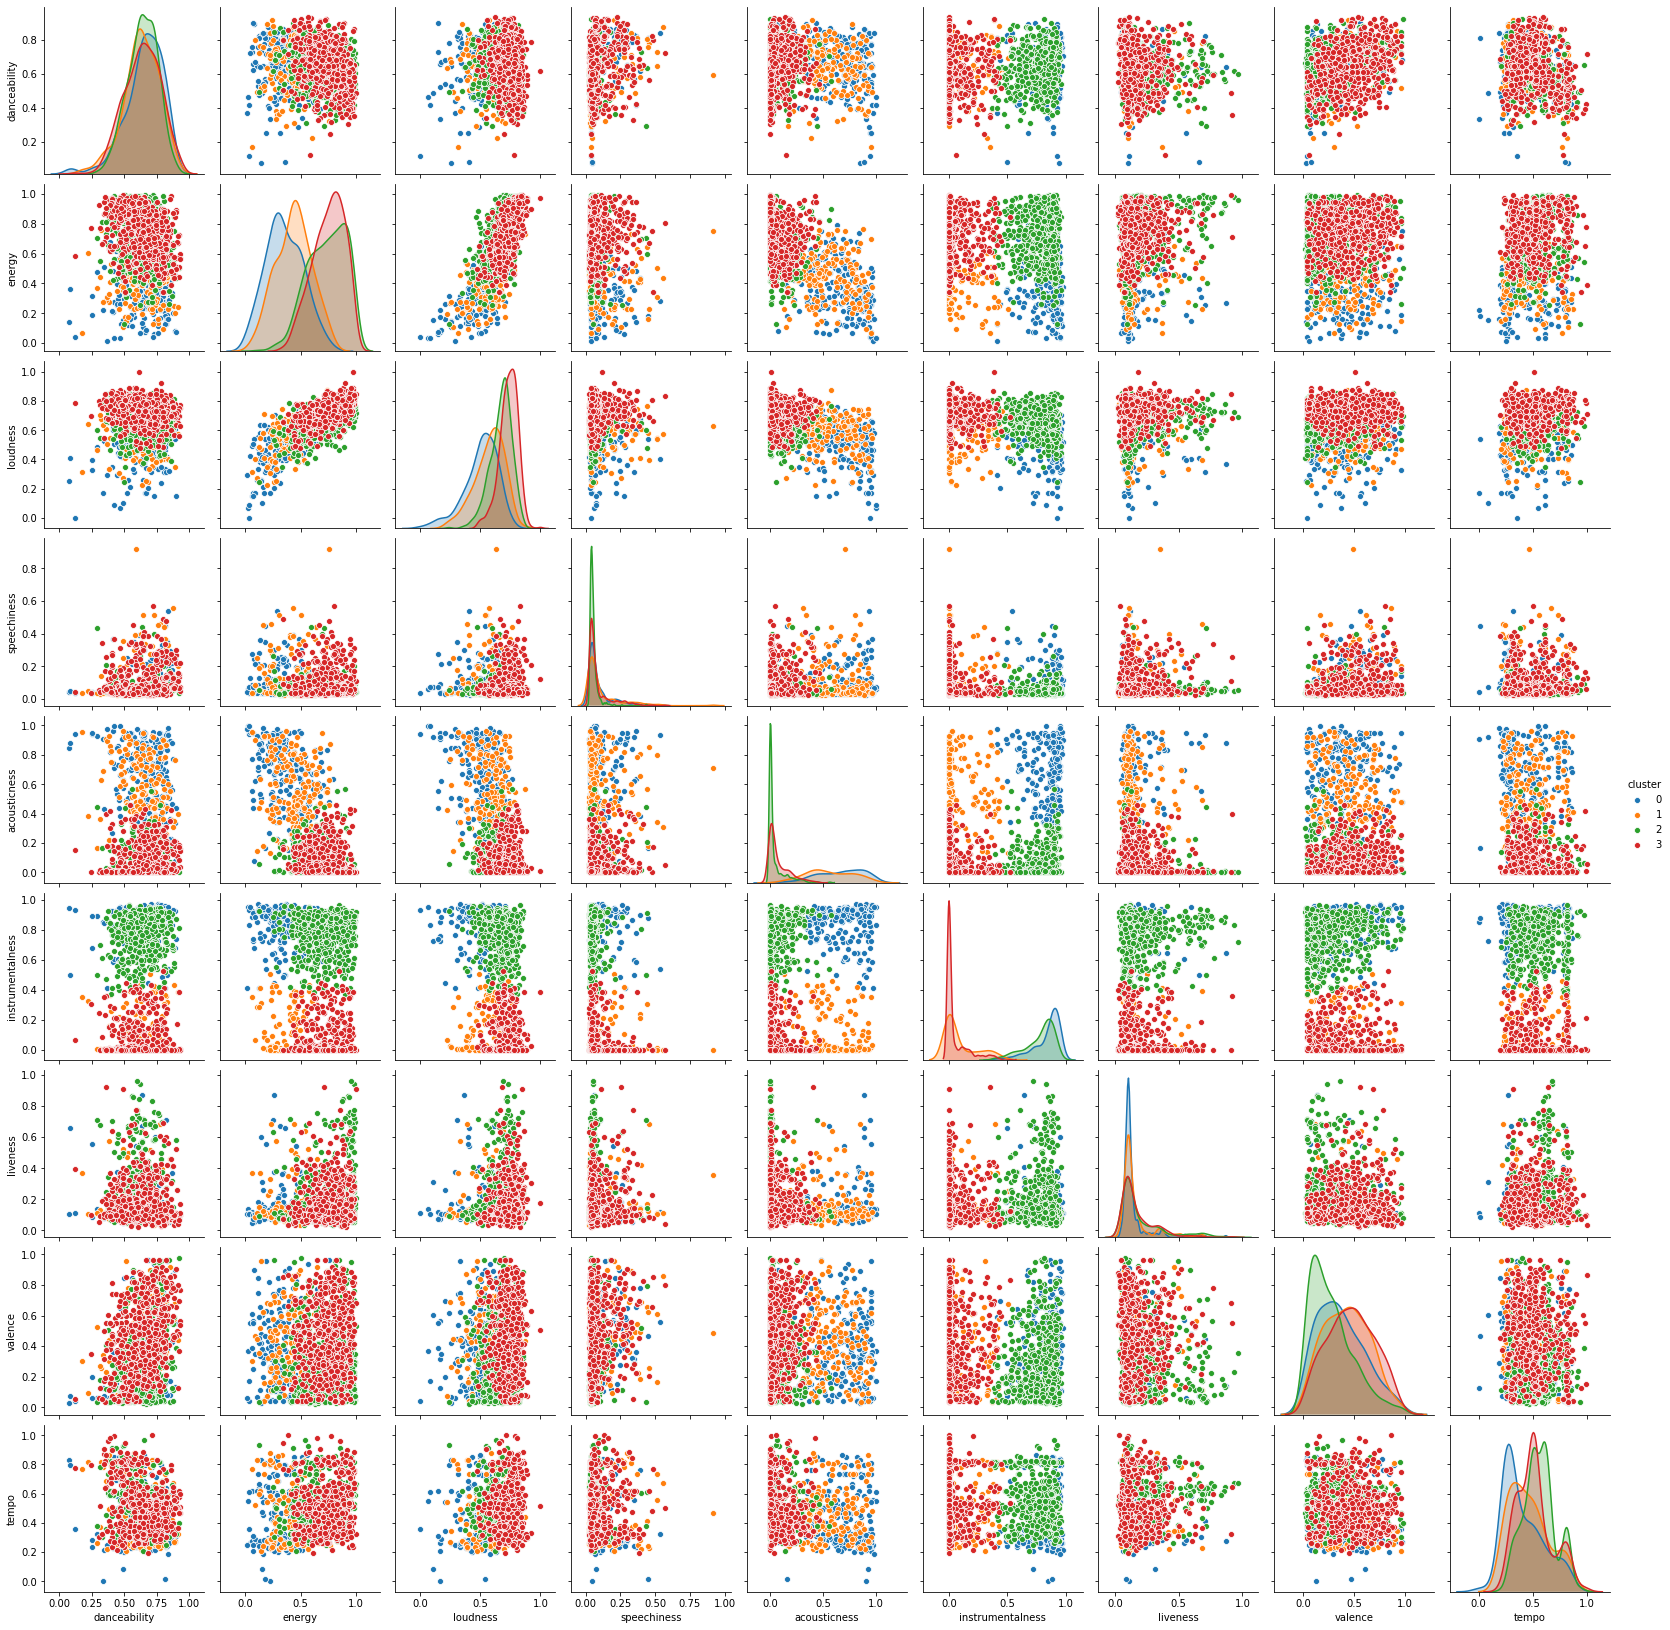

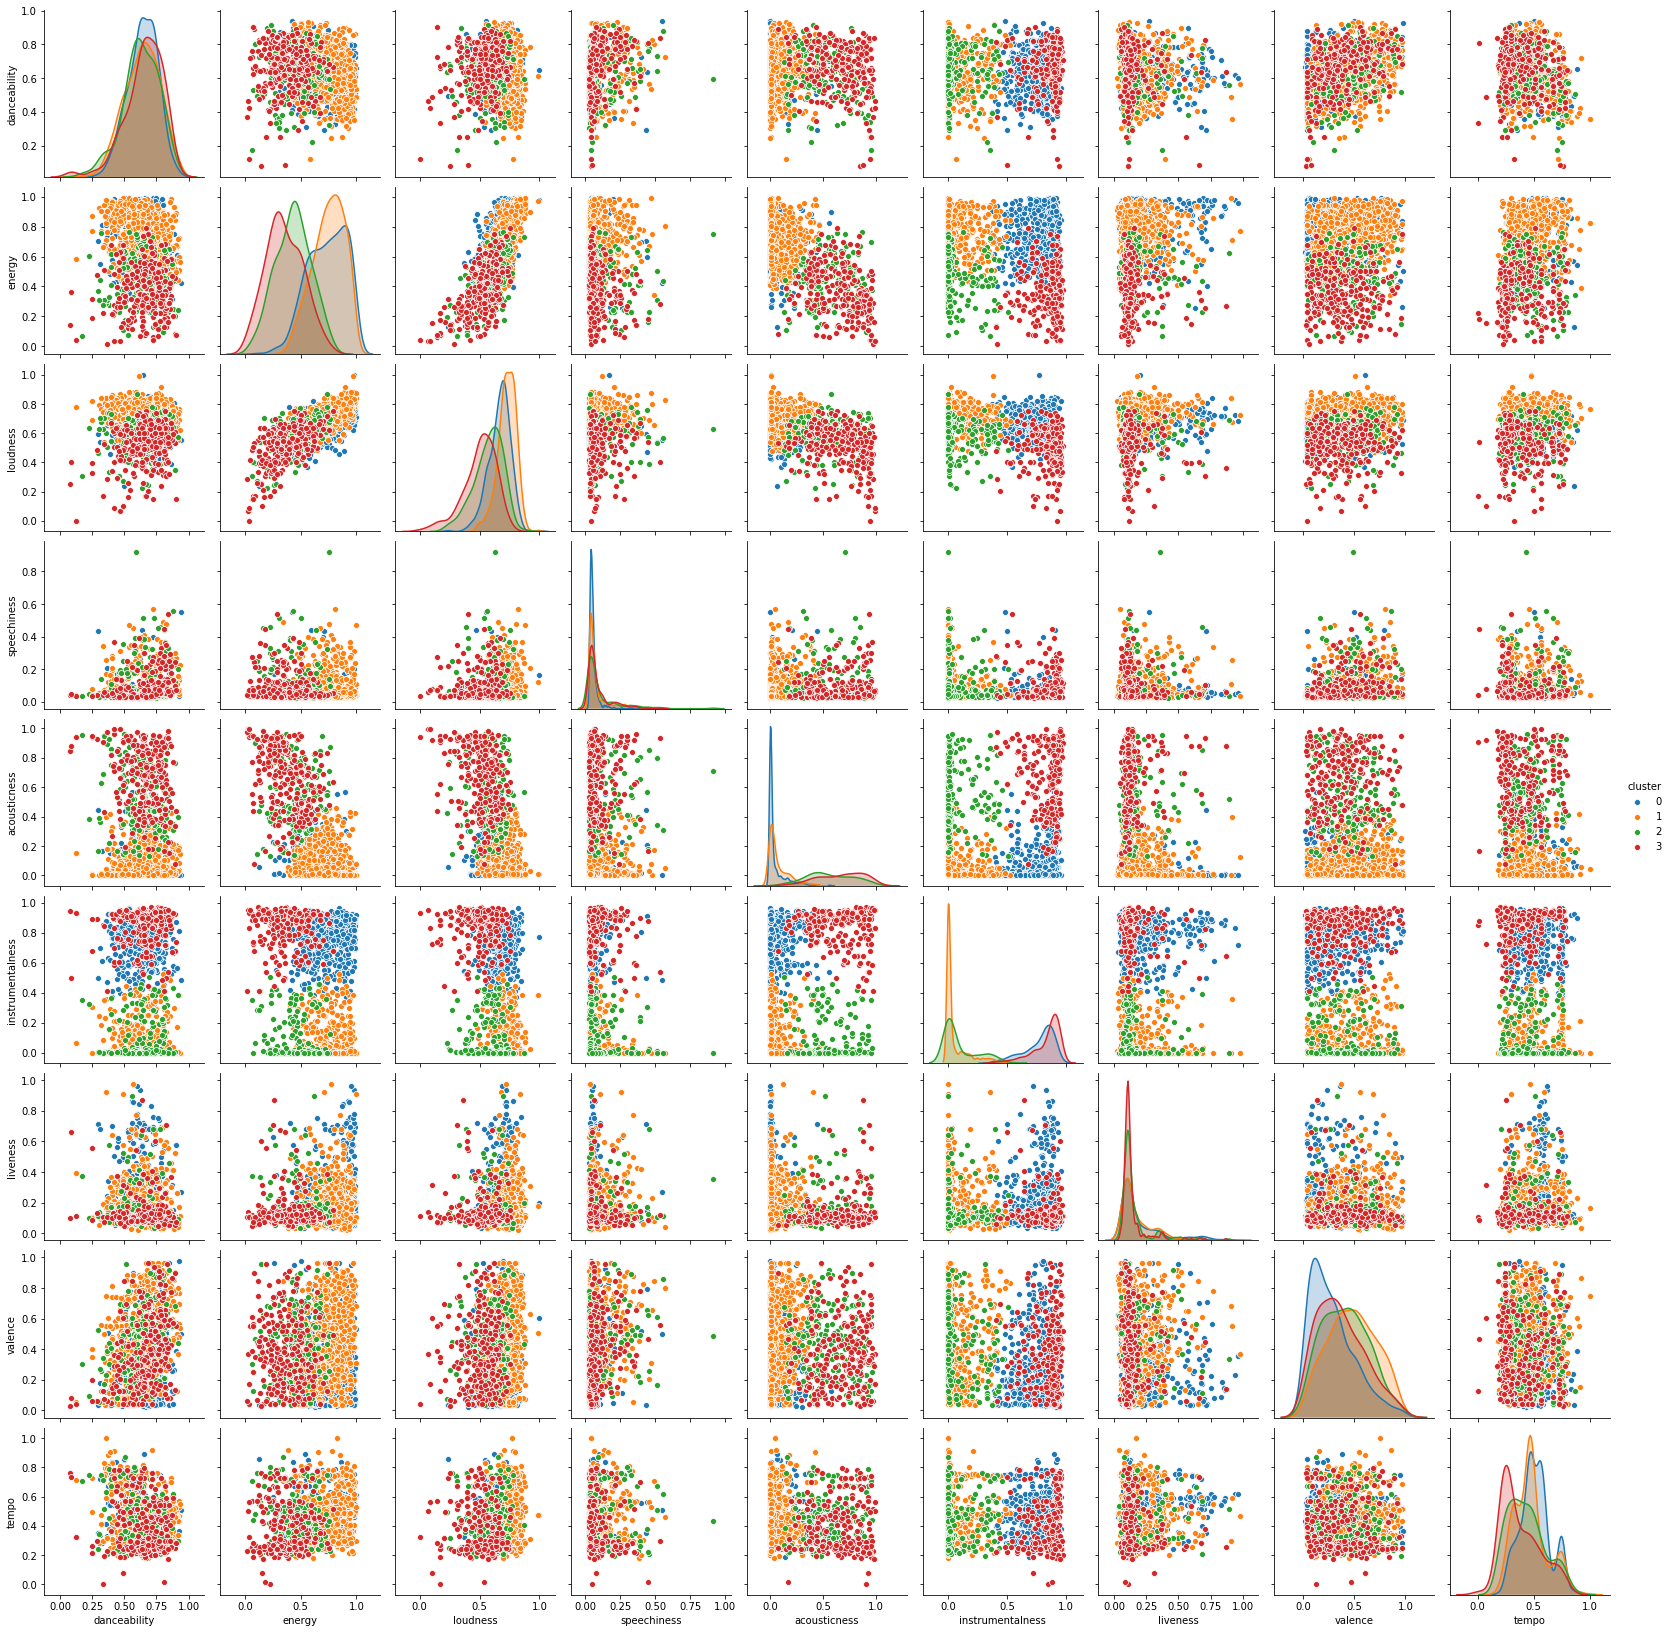

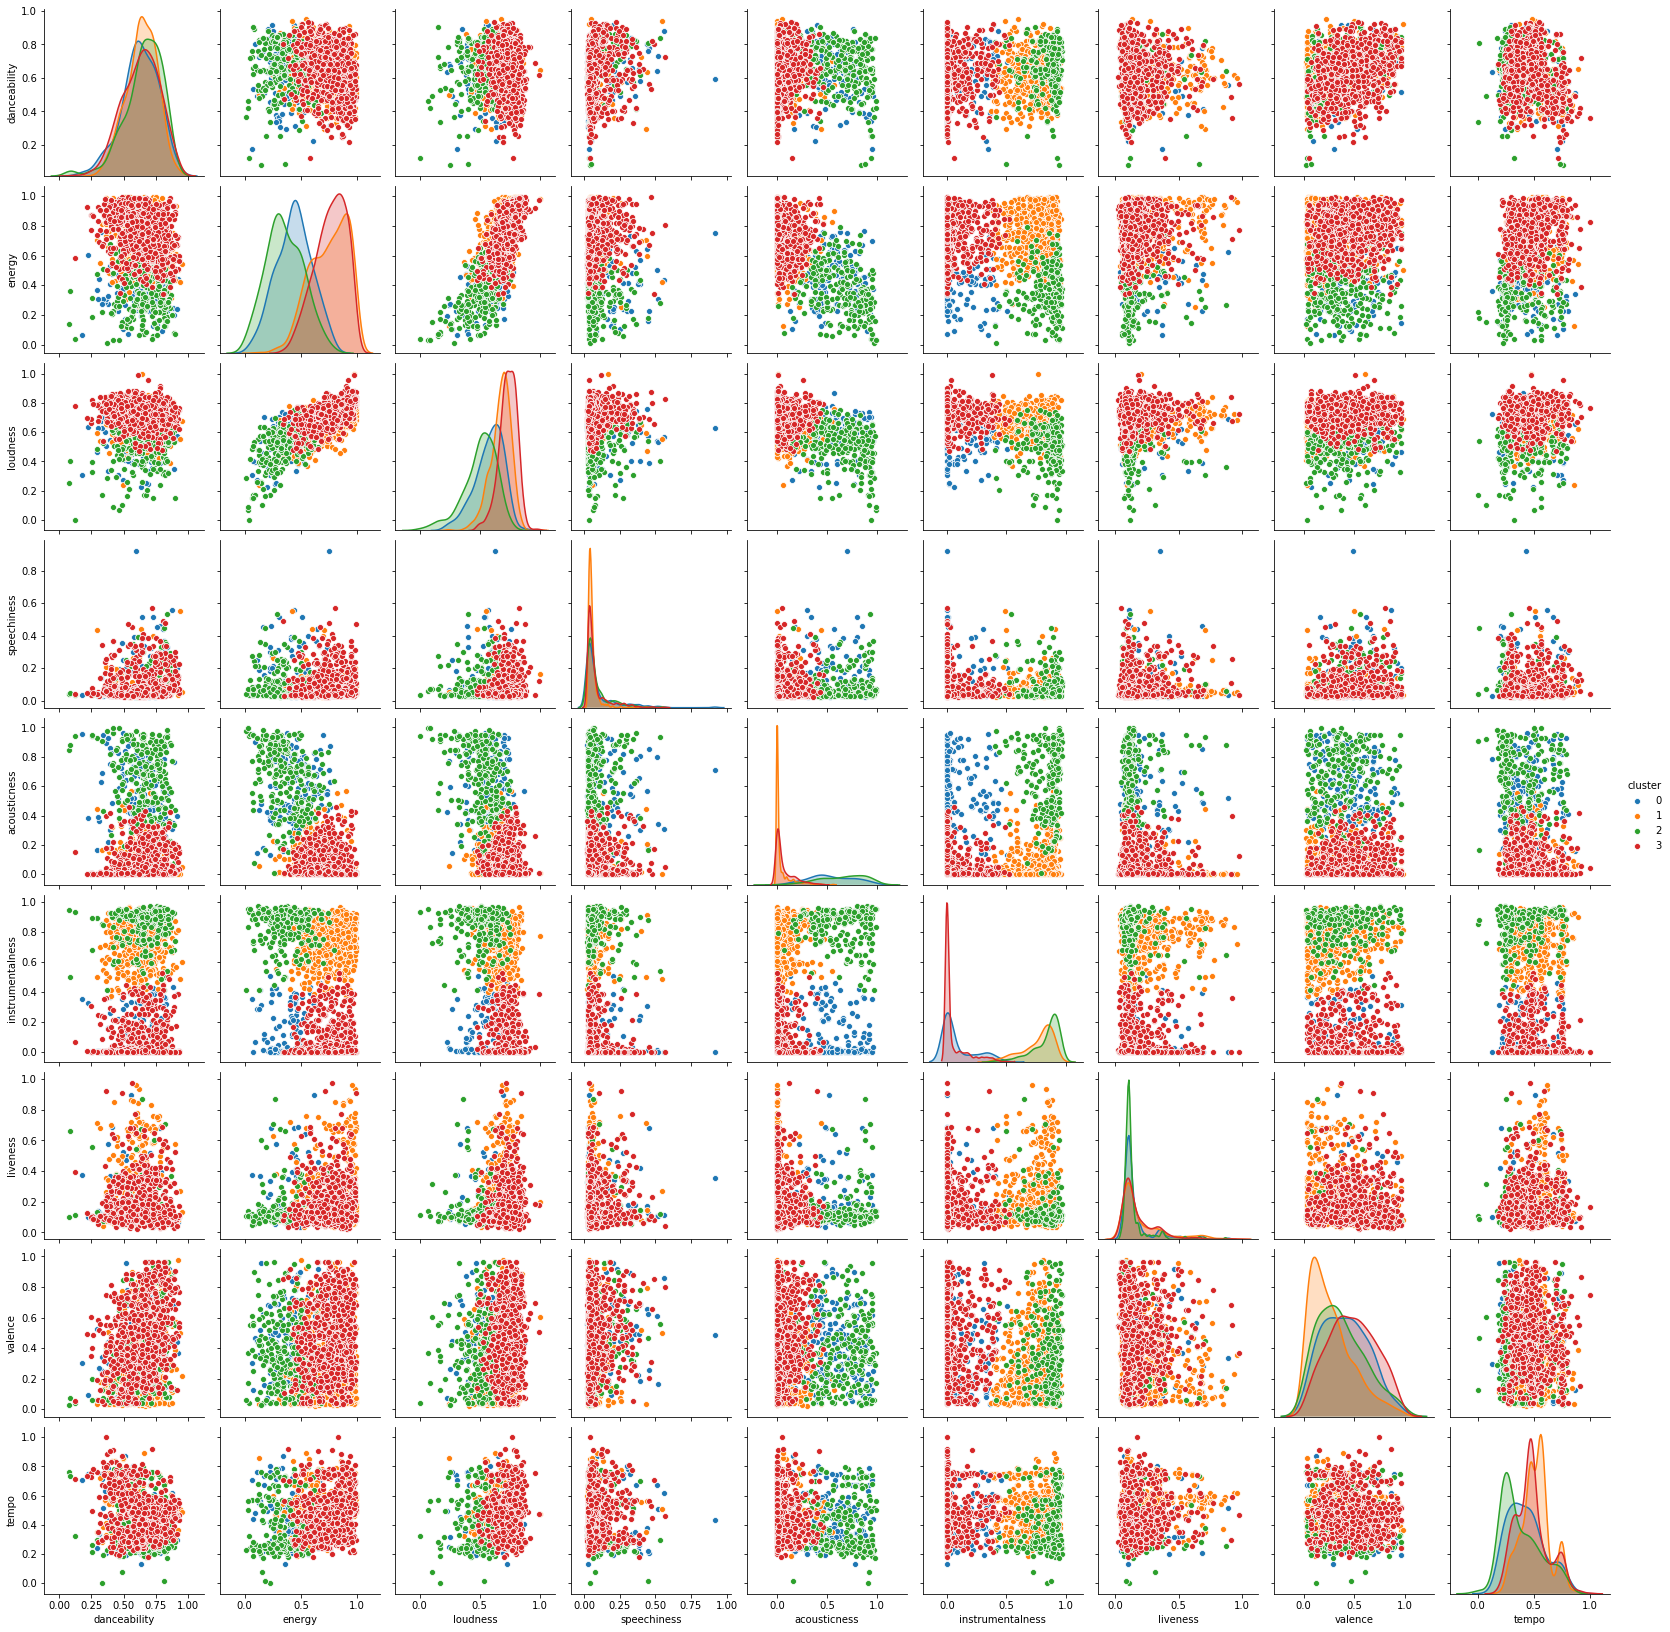

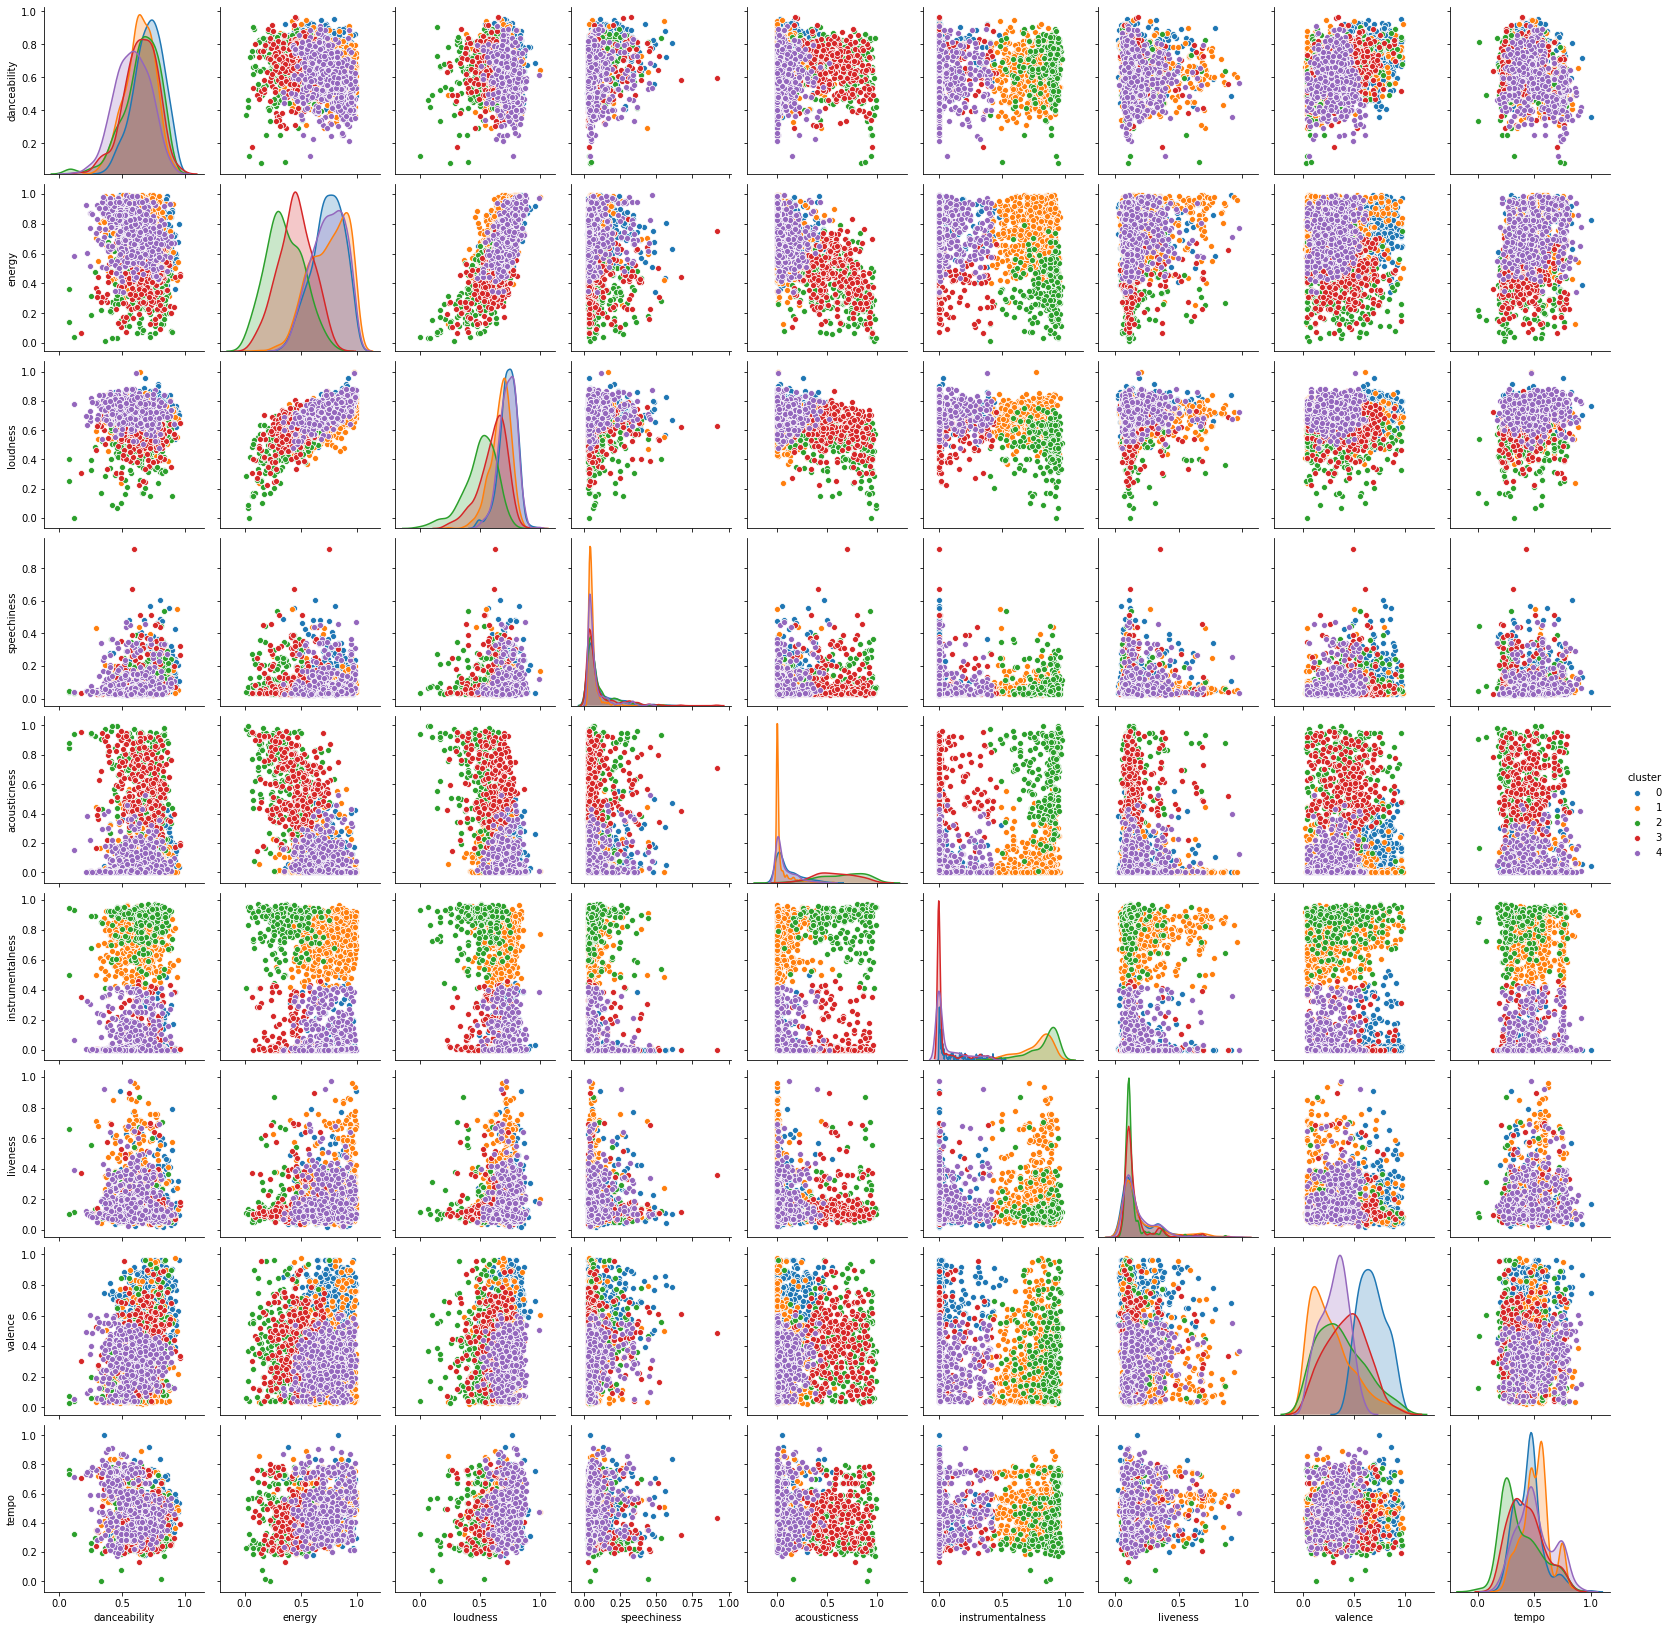

In [15]:
for ind in kmeans_clustering_params_df.index:
    tracks_features_per_clustering_date_df = get_tracks_features_per_clustering_date_df(kmeans_clustering_params_df['clustering_datetime'][ind])
    kmeans_model = KMeans(n_clusters=kmeans_clustering_params_df['k'][ind], random_state=kmeans_clustering_params_df['random_state'][ind]).fit(tracks_features_per_clustering_date_df)
    preds = kmeans_model.predict(tracks_features_per_clustering_date_df)
    tracks_features_per_clustering_date_df['cluster'] = preds
    sns.pairplot(tracks_features_per_clustering_date_df,hue='cluster')